In [1]:
import torch
import torch.nn as nn

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
    )

In [2]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3,stride=2), nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

In [3]:
X= torch.randn(1,1,224,224)

def look_in_net(net, X):
    out = X
    for layer in net:
        out = layer(out)
        print(f"For {layer.__class__.__name__} : ", out.shape)
    

In [4]:
look_in_net(net, X)

For Sequential :  torch.Size([1, 96, 54, 54])
For MaxPool2d :  torch.Size([1, 96, 26, 26])
For Sequential :  torch.Size([1, 256, 26, 26])
For MaxPool2d :  torch.Size([1, 256, 12, 12])
For Sequential :  torch.Size([1, 384, 12, 12])
For MaxPool2d :  torch.Size([1, 384, 5, 5])
For Dropout :  torch.Size([1, 384, 5, 5])
For Sequential :  torch.Size([1, 10, 5, 5])
For AdaptiveAvgPool2d :  torch.Size([1, 10, 1, 1])
For Flatten :  torch.Size([1, 10])


z:\installs\anconda\envs\myenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [15]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

my_transforms = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.ToTensor()]
)

train_dataset = datasets.FashionMNIST(download=False,root="../data", train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(download=False, root="../data", train=False, transform=my_transforms)


train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [16]:
import matplotlib.pyplot as plt
    
def train_net(net,num_epochs=5, lr =0.001):
    def accuracy(y_hat,y):
        return (y_hat.argmax(1)==y).sum()
    
    def full_accuracy(net, data_iter):
        net.eval()
        #     device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'
        net = net.to(device)

        total_acc = 0
        total_num = 0
        with torch.no_grad():
            for X, y in data_iter:
                X = X.to(device)
                y = y.to(device)

                y_hat = net(X)

                total_acc += accuracy(y_hat, y)
                total_num += y.numel()

        return total_acc/total_num
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    
    
    
    train_loss = []
    train_acc = []
    test_acc = []

    net= net.to(device)
    
    for epoch in range(num_epochs):
        acc_value = 0
        total_number = 0
        total_loss= 0
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            total_loss += loss.item()
            acc_value += accuracy(outputs, labels)
            total_number += labels.numel()

        with torch.no_grad():

            print(f"\tEpoch {epoch} : Statistics: ")
            print(f'\tcurrent train loss : {total_loss} / {total_number} : {float(total_loss/total_number)}')
            print(f'\tcurrent train acc : {acc_value}/{total_number} : {float(acc_value/total_number)}')
            print(f'\tcurrent test acc : {float(full_accuracy(net, test_dataloader))}')


            train_loss.append(float(total_loss/total_number))
            test_acc.append(float(full_accuracy(net, test_dataloader)))
            train_acc.append(float(acc_value/total_number))
    
    print("finished")

    num_epochs = num_epochs
#     plt.plot(range(num_epochs), train_loss, label='train loss')
    plt.plot(range(num_epochs), train_acc, label = 'train acc')
    plt.plot(range(num_epochs), test_acc, label = 'test acc')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.plot(range(num_epochs), train_loss, label='train loss')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    

	Epoch 0 : Statistics: 
	current train loss : 1080.5132999420166 / 60000 : 0.01800855499903361
	current train acc : 6000/60000 : 0.10000000149011612
	current test acc : 0.09999999403953552
	Epoch 1 : Statistics: 
	current train loss : 1080.4649813175201 / 60000 : 0.018007749688625337
	current train acc : 6000/60000 : 0.10000000149011612
	current test acc : 0.09999999403953552
	Epoch 2 : Statistics: 
	current train loss : 1080.424013376236 / 60000 : 0.018007066889603934
	current train acc : 6000/60000 : 0.10000000149011612
	current test acc : 0.09999999403953552
	Epoch 3 : Statistics: 
	current train loss : 1080.38720536232 / 60000 : 0.01800645342270533
	current train acc : 6000/60000 : 0.10000000149011612
	current test acc : 0.09999999403953552
	Epoch 4 : Statistics: 
	current train loss : 1080.3516962528229 / 60000 : 0.018005861604213715
	current train acc : 6000/60000 : 0.10000000149011612
	current test acc : 0.09999999403953552
finished


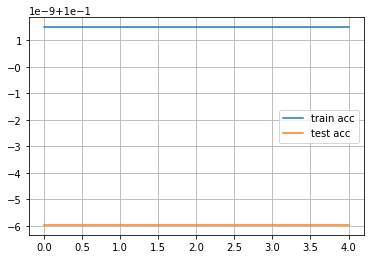

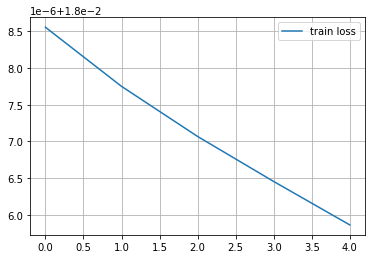

In [17]:
try:
    train_net(net, lr=0.01)
except Exception as e:
    print(e)
    
# its taking a longtime lets rather try on simler network

In [8]:
my_transforms = transforms.Compose(
                [
                    transforms.ToTensor()
                ]
)

train_dataset = datasets.FashionMNIST(download=False,root="../data", train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(download=False, root="../data", train=False, transform=my_transforms)


train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [9]:
#from : https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f
sample_net = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3,padding=1),
                    nn.ReLU(), 
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.ReLU(), 
                    nn.MaxPool2d(kernel_size=2),
                    nn.Dropout(p=0.25),
                    nn.Flatten(),
                    nn.Linear(64 * 14 * 14, 128),nn.ReLU(), nn.Dropout(p=0.5),
                    nn.Linear(128, 10)
                    )

In [10]:
X= torch.randn(1,1,28,28)
look_in_net(sample_net,X)

For Conv2d :  torch.Size([1, 32, 28, 28])
For ReLU :  torch.Size([1, 32, 28, 28])
For Conv2d :  torch.Size([1, 64, 28, 28])
For ReLU :  torch.Size([1, 64, 28, 28])
For MaxPool2d :  torch.Size([1, 64, 14, 14])
For Dropout :  torch.Size([1, 64, 14, 14])
For Flatten :  torch.Size([1, 12544])
For Linear :  torch.Size([1, 128])
For ReLU :  torch.Size([1, 128])
For Dropout :  torch.Size([1, 128])
For Linear :  torch.Size([1, 10])


	Epoch 0 : Statistics: 
	current train loss : 303.5874216556549 / 60000 : 0.005059790360927582
	current train acc : 46540/60000 : 0.7756666541099548
	current test acc : 0.7734999656677246
	Epoch 1 : Statistics: 
	current train loss : 289.22751531004906 / 60000 : 0.004820458588500817
	current train acc : 47055/60000 : 0.784250020980835
	current test acc : 0.7781999707221985
	Epoch 2 : Statistics: 
	current train loss : 278.91721111536026 / 60000 : 0.004648620185256004
	current train acc : 47486/60000 : 0.7914333343505859
	current test acc : 0.7840999960899353
	Epoch 3 : Statistics: 
	current train loss : 270.2014508843422 / 60000 : 0.0045033575147390365
	current train acc : 47803/60000 : 0.7967166900634766
	current test acc : 0.7893999814987183
	Epoch 4 : Statistics: 
	current train loss : 263.23812195658684 / 60000 : 0.00438730203260978
	current train acc : 48157/60000 : 0.8026166558265686
	current test acc : 0.7938999533653259
	Epoch 5 : Statistics: 
	current train loss : 257.14040824

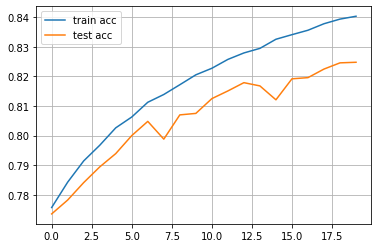

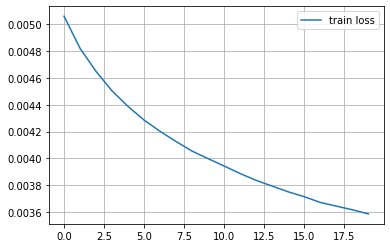

In [12]:
train_net(sample_net, num_epochs=20)

### Exercises

1. Tune the hyperparameters to improve the classification accuracy.
    * its not tuning based on stuff

2. Why are there two 1 × 1 convolutional layers in the NiN block? Remove one of them, and then observe and analyze the experimental phenomena.
    * Not able to train 1x1 I dunno
    
3. Calculate the resource usage for NiN.
    * How do you calculate this. I have been seeing this question for past few exercises.
    1. What is the number of parameters? 
    2. What is the amount of computation?
    3. What is the amount of memory needed during training?
    4. What is the amount of memory needed during prediction?
    
4. What are possible problems with reducing the 384 × 5 × 5 representation to a 10 × 5 × 5 representation in one step. 

    * the size would lead to certain problems likelosing intermediate conv layer info.
